In [1]:
#pip install torch torchvision

# **Import Libraries**

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from copy import deepcopy

# **Set Up**

In [3]:
# SimCLR Augmentations
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset wrapper for contrastive pairs
class SimCLRDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        x, _ = self.dataset[index]
        return simclr_transform(x), simclr_transform(x)

    def __len__(self):
        return len(self.dataset)

In [4]:
class SimCLRModel(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        base_model = models.resnet50(pretrained=False)

        # Remove the final FC layer and keep only the encoder
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Identity()  # No classification layer

        self.encoder = base_model

        # Add projection head (MLP)
        self.projector = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)  
        z = self.projector(h)
        return F.normalize(z, dim=1)

In [5]:
def contrastive_loss(z1, z2, temperature=0.5):
    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

    labels = torch.arange(N).repeat(2)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(z.device)
    mask = torch.eye(2 * N).bool().to(z.device)
    labels = labels[~mask].view(2 * N, -1)

    sim = sim[~mask].view(2 * N, -1) / temperature
    loss = -torch.log((torch.exp(sim) * labels).sum(1) / torch.exp(sim).sum(1))
    return loss.mean()

In [6]:
dataset_path = "/kaggle/input/eurosat-dataset/EuroSAT"

# Load full dataset without transforms
eurosat_raw = datasets.ImageFolder(root=dataset_path, transform=lambda x: x)

# Train-Validation-Test
train_len = int(0.7 * len(eurosat_raw))
val_len = int(0.15 * len(eurosat_raw))
test_len = len(eurosat_raw) - train_len - val_len
train_ds, val_ds, test_ds = random_split(eurosat_raw, [train_len, val_len, test_len])

# SimCLRDataset wrapper
simclr_train = SimCLRDataset(train_ds)
simclr_val = SimCLRDataset(val_ds)

# DataLoaders
train_loader = DataLoader(simclr_train, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(simclr_val, batch_size=64, shuffle=False, num_workers=2)
test_loader= DataLoader(test_ds, batch_size=64, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Encoder Trainig Loop**

In [8]:
# Track pretext losses per epoch
pretext_losses = []

# Create SimCLR model and optimizer
model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

best_loss = float('inf')  # Initialize best loss

epochs = 100
# SimCLR Pretext Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x1, x2 in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Save best encoder checkpoint
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.encoder.state_dict(), "best_simclr_encoder.pth")
        print(f"Saved best encoder at epoch {epoch+1} with loss {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/100], Loss: 4.0544
Saved best encoder at epoch 1 with loss 4.0544
Epoch [2/100], Loss: 3.7447
Saved best encoder at epoch 2 with loss 3.7447
Epoch [3/100], Loss: 3.6237
Saved best encoder at epoch 3 with loss 3.6237
Epoch [4/100], Loss: 3.5543
Saved best encoder at epoch 4 with loss 3.5543
Epoch [5/100], Loss: 3.5030
Saved best encoder at epoch 5 with loss 3.5030
Epoch [6/100], Loss: 3.4711
Saved best encoder at epoch 6 with loss 3.4711
Epoch [7/100], Loss: 3.4418
Saved best encoder at epoch 7 with loss 3.4418
Epoch [8/100], Loss: 3.4175
Saved best encoder at epoch 8 with loss 3.4175
Epoch [9/100], Loss: 3.3984
Saved best encoder at epoch 9 with loss 3.3984
Epoch [10/100], Loss: 3.3869
Saved best encoder at epoch 10 with loss 3.3869
Epoch [11/100], Loss: 3.3755
Saved best encoder at epoch 11 with loss 3.3755
Epoch [12/100], Loss: 3.3619
Saved best encoder at epoch 12 with loss 3.3619
Epoch [13/100], Loss: 3.3528
Saved best encoder at epoch 13 with loss 3.3528
Epoch [14/100], L

# **Downstream Classifier (Linear Evaluation)**

In [9]:
# Apply classification transform to datasets
classifier_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply to subsets
train_ds.dataset.transform = classifier_transform
val_ds.dataset.transform = classifier_transform
test_ds.dataset.transform = classifier_transform

# Dataloaders for downstream classification
train_loader_cls = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader_cls = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader_cls = DataLoader(test_ds, batch_size=64, shuffle=False)

# Load best pretrained encoder weights before linear evaluation
model.encoder.load_state_dict(torch.load("best_simclr_encoder.pth", map_location=device))

# Freeze encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Define linear classifier
classifier = nn.Linear(2048, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)

# Plot Points 
downstream_losses = []
downstream_accuracies = []
validation_accuracies = []

# Early Stop
patience = 20
best_val_acc = 0
epochs_no_improve = 0
best_model_state = None

num_epochs = 100
# Train downstream classifier
for epoch in range(num_epochs): 
    classifier.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader_cls:
        images, labels = images.to(device), labels.to(device)
        features = model.encoder(images)
        outputs = classifier(features)
        loss = criterion(outputs, labels)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    downstream_losses.append(running_loss / len(train_loader_cls))
    downstream_accuracies.append(train_acc)

    # Validation
    classifier.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader_cls:
            images, labels = images.to(device), labels.to(device)
            features = model.encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    validation_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = deepcopy(classifier.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

Epoch 1 - Train Acc: 0.8719, Val Acc: 0.8751
Epoch 2 - Train Acc: 0.8931, Val Acc: 0.8951
Epoch 3 - Train Acc: 0.8975, Val Acc: 0.9091
Epoch 4 - Train Acc: 0.9060, Val Acc: 0.9079
Epoch 5 - Train Acc: 0.9072, Val Acc: 0.9032
Epoch 6 - Train Acc: 0.9087, Val Acc: 0.9230
Epoch 7 - Train Acc: 0.9125, Val Acc: 0.9173
Epoch 8 - Train Acc: 0.9140, Val Acc: 0.9114
Epoch 9 - Train Acc: 0.9133, Val Acc: 0.9158
Epoch 10 - Train Acc: 0.9132, Val Acc: 0.9131
Epoch 11 - Train Acc: 0.9190, Val Acc: 0.9289
Epoch 12 - Train Acc: 0.9213, Val Acc: 0.9207
Epoch 13 - Train Acc: 0.9183, Val Acc: 0.9054
Epoch 14 - Train Acc: 0.9194, Val Acc: 0.9237
Epoch 15 - Train Acc: 0.9253, Val Acc: 0.9274
Epoch 16 - Train Acc: 0.9232, Val Acc: 0.9205
Epoch 17 - Train Acc: 0.9244, Val Acc: 0.9240
Epoch 18 - Train Acc: 0.9246, Val Acc: 0.9294
Epoch 19 - Train Acc: 0.9244, Val Acc: 0.9143
Epoch 20 - Train Acc: 0.9219, Val Acc: 0.8978
Epoch 21 - Train Acc: 0.9258, Val Acc: 0.9148
Epoch 22 - Train Acc: 0.9264, Val Acc: 0.92

In [10]:
if best_model_state is not None:
    classifier.load_state_dict(best_model_state)
    torch.save(classifier.state_dict(), "best_downstream_classifier.pth")
    print("Best classifier model saved as 'best_downstream_classifier.pth'")

Best classifier model saved as 'best_downstream_classifier.pth'


In [11]:
# Load the best pretrained encoder 
model.encoder.load_state_dict(torch.load("best_simclr_encoder.pth", map_location=device))

# Put encoder & classifier in eval mode
model.eval()
classifier.eval()

# Test Accuracy
correct_test, total_test = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader_cls:
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)          # frozen encoder forward
        outputs = classifier(features)          # linear head
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_acc = 100.0 * correct_test / total_test
print(f"Final Test Accuracy: {test_acc:.2f}%")


Final Test Accuracy: 86.59%


# **Visualization**

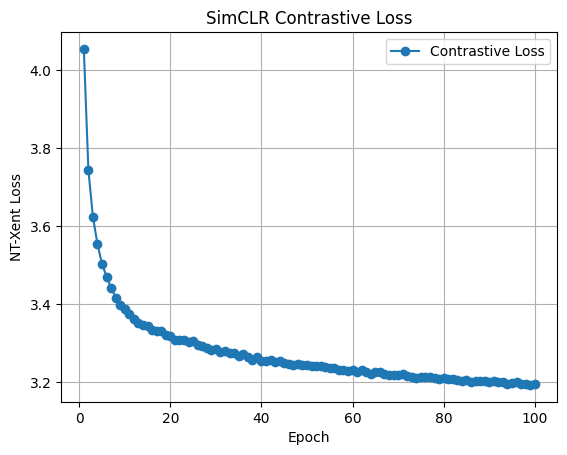

In [12]:
# Pretext loss curve
plt.plot(range(1, epochs + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid()
plt.show()

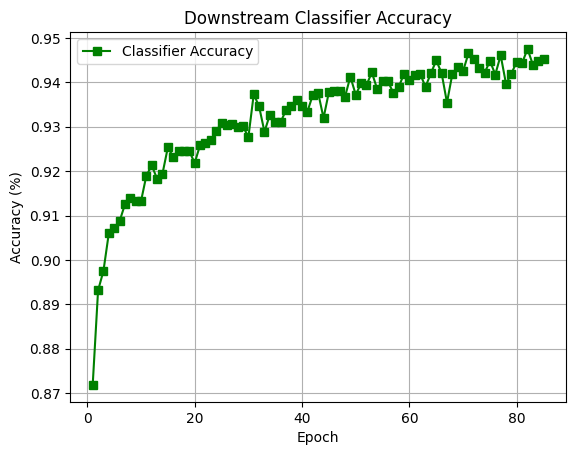

In [13]:
# Downstream Classifier Accuracy (Training)
plt.plot(range(1, len(downstream_accuracies)+1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

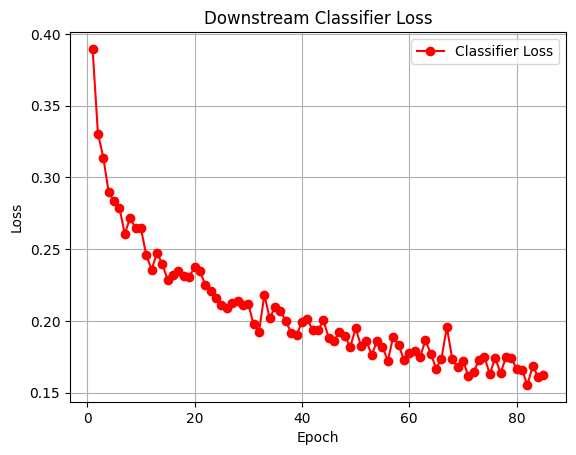

In [14]:
# Downstream Classifier Loss
plt.plot(range(1, len(downstream_losses)+1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()